# Glaciated basin runoff analysis

This will work as the prototype for how to select a glaciated basin, simulate its glaciers and analyse the outputs. Ideally this will be made into a module later for simpler use.

In [52]:
import geopandas as gpd
import shapely.geometry as shpg
from matplotlib import pyplot as plt

In [1]:
# Begin by downloading the rgi data
from oggm import utils
utils.get_rgi_dir(version='62')

'/home/erik/OGGM/rgi/RGIV62'

## Access a region
![rgi-map](https://www.researchgate.net/profile/Tobias_Bolch/publication/264125572/figure/fig1/AS:295867740377088@1447551774164/First-order-regions-of-the-RGI-with-glaciers-shown-in-red-Region-numbers-are-those-of.png)
*Source: [the RGI consortium](http://www.glims.org/RGI/randolph60.html)*

In [8]:
# This fetches Central Europe
fr = utils.get_rgi_region_file('11', version='62')

In [9]:
gdf = gpd.read_file(fr)

In [10]:
# Select glaciers per attribute
gdf_sel = gdf.loc[gdf.O2Region == '2']

## Selecting glaciers in a basin

In [12]:
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

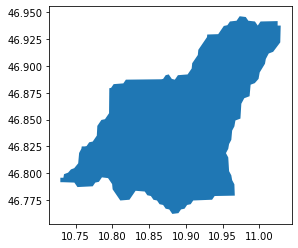

In [14]:
basin.plot();

We can select all glaciers that lies within a shape

In [28]:
def select_glaciers(basin, gdf):
    '''Function to select the glaciers within a basin.
    -----
    args:
    basin: geopandas dataframe of the basin (one shapefile)
    gdf: geopandas dataframe containing the glaciers of the
    region.
    
    returns:
    geopandas dataframe of the glaciers within the basin.
    
    '''
    in_bas = [basin.geometry.contains(shpg.Point(x, y))[0]
              for (x, y) in zip(gdf.CenLon, gdf.CenLat)]
    return gdf.loc[in_bas]

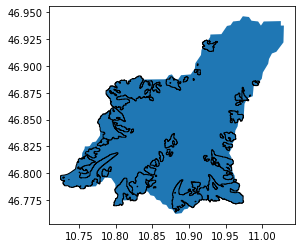

In [23]:
ax = basin.plot();
gdf_sel = select_glaciers(basin, gdf)
gdf_sel.plot(ax=ax, edgecolor='k');

This gives us the RGIIDs which can be used to initilaize gdirs for simulations. 

In [29]:
from oggm import cfg, workflow, tasks

In [30]:
# Some initial cfg.
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['border'] = 80
# Set the path
cfg.PATHS['working_dir'] = '/home/erik/data/oggm_output/'



2021-05-03 16:49:28: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-05-03 16:49:28: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-05-03 16:49:28: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-05-03 16:49:28: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2021-05-03 16:49:28: oggm.cfg: Multiprocessing switched ON after user settings.
2021-05-03 16:49:28: oggm.cfg: PARAMS['border'] changed from `40` to `80`.


In [31]:
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/no_match'
# Initialize the gdirs
gdirs = workflow.init_glacier_directories(gdf_sel,
                                          from_prepro_level=5,
                                          prepro_border=80,
                                          prepro_base_url=base_url )

2021-05-03 16:53:03: oggm.workflow: init_glacier_directories from prepro level 5 on 54 glaciers.
2021-05-03 16:53:03: oggm.workflow: Execute entity task gdir_from_prepro on 54 glaciers
100% of  34.9 MiB |######################| Elapsed Time: 0:00:13 Time:  0:00:13


Now we can get the climate data and process it for our glaciers

In [34]:
from oggm.shop import gcm_climate
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs,
                                 # recognize the climate file for later
                                 filesuffix='_CCSM4_{}'.format(rcp),
                                 # temperature projections
                                 fpath_temp=ft,
                                 # precip projections
                                 fpath_precip=fp,
                                 );

2021-05-03 17:06:19: oggm.workflow: Execute entity task process_cmip_data on 54 glaciers
2021-05-03 17:06:38: oggm.workflow: Execute entity task process_cmip_data on 54 glaciers
2021-05-03 17:06:59: oggm.workflow: Execute entity task process_cmip_data on 54 glaciers
2021-05-03 17:07:19: oggm.workflow: Execute entity task process_cmip_data on 54 glaciers


In [39]:
def run_hydro_projections(gdirs, rcps):
    '''Small wrapper for running hydro simulations
    args:
    gdirs: glacier directories.
    rcps: list of rcp scenarios to run.
    '''
    for rcp in rcps:
        rid = f'_CCSM4_{rcp}'
        workflow.execute_entity_task(
                             tasks.run_with_hydro,  gdirs,
                             run_task=tasks.run_from_climate_data,
                             ys=2020,
                             # Use gcm_data
                             climate_filename='gcm_data',
                             # Use the scenario
                             climate_input_filesuffix=rid,
                             # When to start?
                             init_model_filesuffix='_historical',
                             # Good naming for recognizing later
                             output_filesuffix=rid,
                             # Store monthyl?
                             store_monthly_hydro=True,
                            )
                             

In [40]:
# Lets try and simulate everything for one rcp.
rcps = ['rcp26']
run_hydro_projections(gdirs, rcps)

2021-05-03 17:21:28: oggm.workflow: Execute entity task run_with_hydro on 54 glaciers


In [43]:
output_suffix = '_rofental_CCMSM4_rcp26'
ds = utils.compile_run_output(gdirs,
                              input_filesuffix='_CCSM4_rcp26',
                              output_filesuffix=output_suffix)

2021-05-03 18:19:45: oggm.utils: Applying global task compile_run_output on 54 glaciers
2021-05-03 18:19:45: oggm.utils: Applying compile_run_output on 54 gdirs.


In [96]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()
runoff_vars = ['melt_off_glacier', 'melt_on_glacier',
               'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
df_runoff = df_runoff.unstack(level=0)

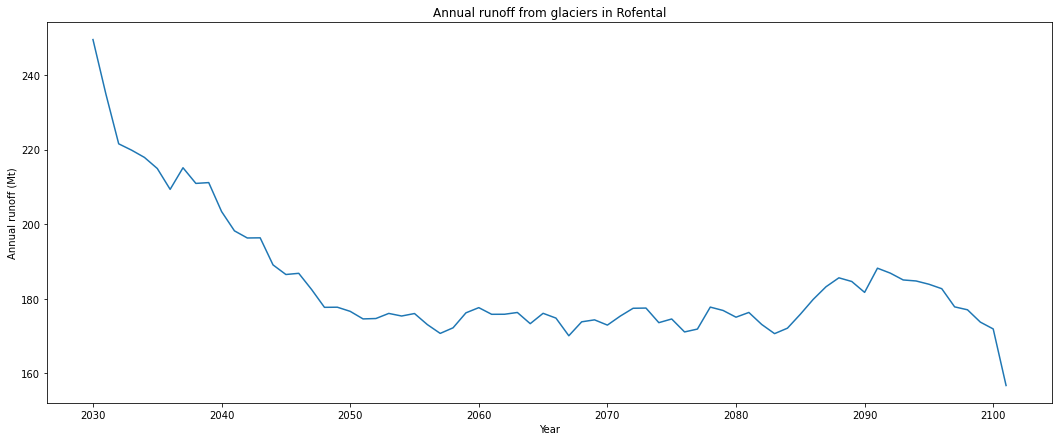

In [99]:
f, ax = plt.subplots(figsize=(18, 7))
df_runoff.sum(axis=1).rolling(window=11).mean().plot(ax=ax)
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title('Annual runoff from glaciers in Rofental');